In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d #unsure if needed

# suppress scientific notation for now
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.4f}'.format

In [2]:
v=0.25
lbg=0.1
k=0.0003
kbg=0.4
I0=300.0
mumax=1.2
rhomax=0.2
m=15.0
qmax=0.04
qmin=0.004
h=120.0
d=10.0
# Redfield ratio = 0.022 for q

zmax = 10.0 # meters
tmax = 20.0 #days
dz = 0.1
dt = dz**2/40 # change this 
dt

0.00025000000000000006

zmax (meters)| dz | tmax (days)| dt | looks right? | scale of A
--- | --- | --- | --- | --- | ---
20.0 | 0.5 | 10.0 | 0.00625 | yes | 1.25 - 1.5
30.0 | 0.5 | 10.0 | 0.00625 | yes | 1.0 - 1.4
30.0 | 0.5 | 20.0 | 0.00625 | yes | 0.0025 - 0.0028
50.0 | 0.5 | 20.0 | 0.00625 | yes | 0.0021 - 0.0028
20.0 | 0.5 | 30.0 | 0.00625 | no | 
20.0 | 0.5 | 40.0 | 0.00625 | no | 
20.0 | 0.5 | 20.0 | 6.25e-05 | no | 


[Derivation of 3-point first derivative approximation](http://home.cc.umanitoba.ca/~farhadi/Math2120/Numerical%20Differentiation.pdf)

In [3]:
# assuming homogeneous initial conditions over z
z_grid = np.arange(0,zmax,dz)
time_steps = np.arange(0,tmax,dt)

A_0 = np.ones(int(zmax/dz))*300
Rb_0 = np.ones(int(zmax/dz))*2.2
Rd_0 = np.ones(int(zmax/dz))*30
I_0 = np.ones(int(zmax/dz))*I0

# define results of matrices
# rows - deeper z-values, cols - time steps forward
A = np.zeros((int(zmax/dz),int(tmax/dt)))
Rb = np.zeros((int(zmax/dz),int(tmax/dt)))
Rd = np.zeros((int(zmax/dz),int(tmax/dt)))
I = np.zeros((int(zmax/dz),int(tmax/dt)))

A[:,0] = A_0
Rb[:,0] = Rb_0
Rd[:,0] = Rd_0
I[:,0] = I_0

A.shape

(100, 79999)

In [4]:
time_steps.shape

(80000,)

In [5]:
z_grid.shape

(100,)

In [6]:
def p(I,q):
    return mumax * (1.0 - qmin/q) * (I/(h + I))

def rho(q, Rd):
    return rhomax * (qmax-q)/(qmax-qmin) * ( Rd/(m + Rd) )

In [7]:
# check - dt must be much smaller than dz for stability (try to get exact expression later? ) 
dt/dz**2

0.025

In [8]:
def next_step(z,A,Rb,Rd,I):
    """Calculates next step for input arrays of length zmax."""
    
    A_next = np.zeros(len(A))
    Rb_next = np.zeros(len(A))
    Rd_next =np.zeros(len(A))
    I_next = np.zeros(len(A))
    
    q = Rb[1:-1]/A[1:-1]
    pp = p(I[1:-1],q)
    rrho = rho(q,Rd[1:-1])
    
    A_next[1:-1] = dt*(d/(dz**2) - v/(2*dz))*A[2:] \
    + (1 + dt*pp - dt*lbg - 2*dt*d/(dz**2))*A[1:-1] \
    + dt*(d/(dz**2)- v/(2*dz))*A[:-2]
    A_next[0] = 4*d/(2*v*dz + 3*d)*A_next[1] - d/(2*v*dz + 3*d)*A_next[2]
    A_next[-1] = (4*A_next[-2] - A_next[-3])/3
    
    Rb_next[1:-1] = dt*(d/(dz**2) - v/(2*dz))*Rb[2:] \
    + (1 - dt*lbg - 2*dt*d/(dz**2))*Rb[1:-1] \
    + dt*(d/(dz**2) - v/(2*dz))*Rb[:-2] \
    + dt*rrho*A[1:-1]
    Rb_next[0] = +4*d/(2*v*dz + 3*d)*Rb_next[1] - d/(2*v*dz + 3*d)*Rb_next[2]
    Rb_next[-1] = (4*Rb_next[-2] - Rb_next[-3])/3
    
    Rd_next[1:-1] = d*dt/(dz**2)*Rd[2:] \
    + (1 - 2*dt*d/(dz**2))*Rd[1:-1] \
    + d*dt/(dz**2)*Rd[:-2] \
    - dt*rrho*A[1:-1] + dt*lbg*Rb[1:-1]
    Rd_next[0] = (4*Rd[1]/3 - Rd[2])/3
    Rd_next[-1] = -Rd[-3]/3 + 4*Rd[-2]/3 + 2*v*dz*Rb[-1]/(3*d)
    
    I_next[1:] = -(dt*k*A[1:] + dt*kbg*z[1:] - 1)*I[1:]
    I_next[0] = I0
    
    return A_next, Rb_next, Rd_next, I_next

In [9]:
i = 1
for t in time_steps[:-2]:
    A[:,i],Rb[:,i],Rd[:,i],I[:,i] = next_step(z_grid,A[:,i-1],Rb[:,i-1],Rd[:,i-1],I[:,i-1])
    i = i+1

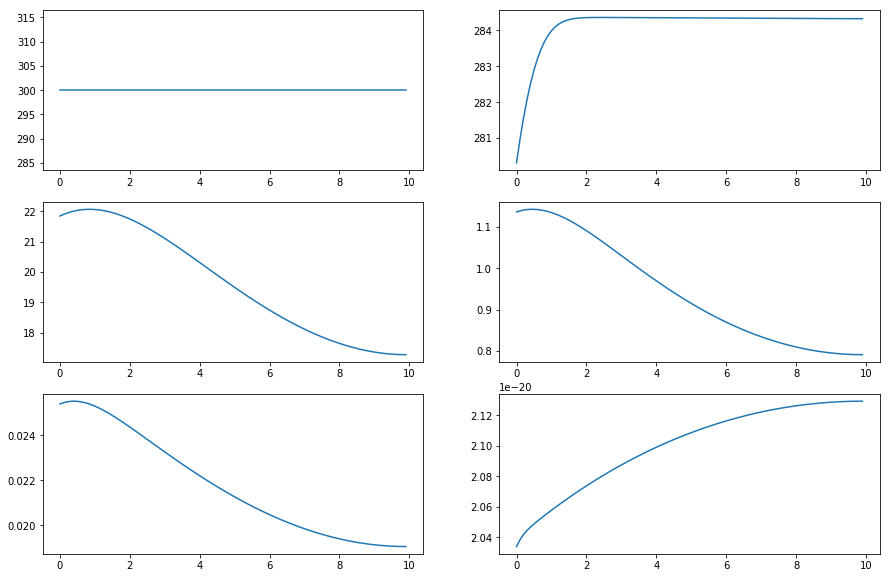

In [10]:
fig, axs = plt.subplots(3,2, figsize=(15,10))

axs[0,0].plot(z_grid,A[:,0])
axs[0,1].plot(z_grid,A[:,100])
axs[1,0].plot(z_grid,A[:,5000])
axs[1,1].plot(z_grid,A[:,10000])
axs[2,0].plot(z_grid,A[:,16000])
axs[2,1].plot(z_grid,A[:,-1])

In [26]:
A.shape # (100, 79999)
len(z_grid) # 100
len(time_steps[:-1]) # 79999

79999

Text(0.5, 0.92, 'A - Phytoplankton')

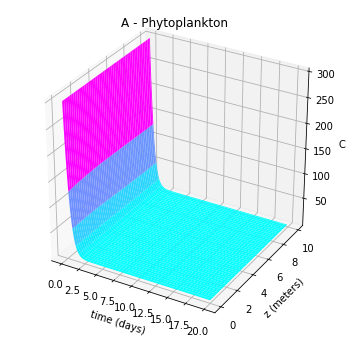

In [50]:
T,Z = np.meshgrid(time_steps[:-1],z_grid)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T,Z, A,cmap='cool')
ax.set_xlabel('time (days)')
ax.set_ylabel('z (meters)')
ax.set_zlabel('C')
ax.set_title('A - Phytoplankton')

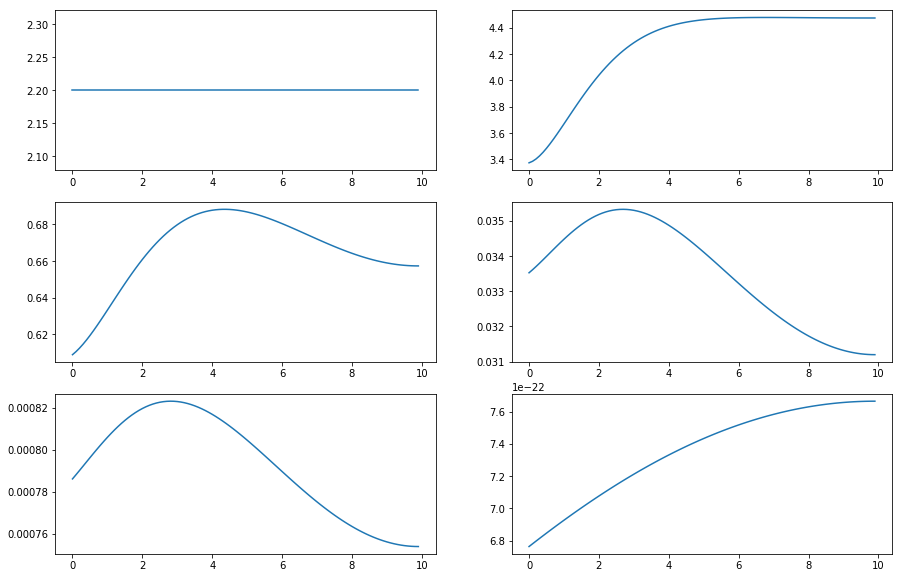

In [11]:
fig, axs = plt.subplots(3,2, figsize=(15,10))

#axs[0,0].set_ylim(0,5)
#axs[0,1].set_ylim(0,5)
#axs[1,0].set_ylim(0,5)
#axs[1,1].set_ylim(0,5)
#axs[2,0].set_ylim(0,5)
#axs[2,1].set_ylim(0,5)

axs[0,0].plot(z_grid,Rb[:,0])
axs[0,1].plot(z_grid,Rb[:,1000])
axs[1,0].plot(z_grid,Rb[:,5000])
axs[1,1].plot(z_grid,Rb[:,10000])
axs[2,0].plot(z_grid,Rb[:,16000])
axs[2,1].plot(z_grid,Rb[:,-1])

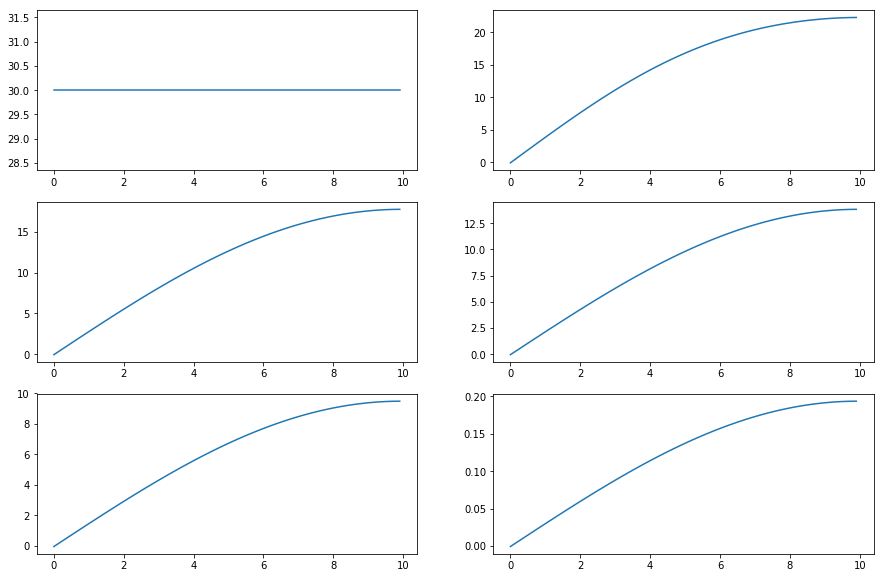

In [12]:
fig, axs = plt.subplots(3,2, figsize=(15,10))

axs[0,0].plot(z_grid,Rd[:,0])
axs[0,1].plot(z_grid,Rd[:,4000])
axs[1,0].plot(z_grid,Rd[:,8000])
axs[1,1].plot(z_grid,Rd[:,12000])
axs[2,0].plot(z_grid,Rd[:,18000])
axs[2,1].plot(z_grid,Rd[:,-1])

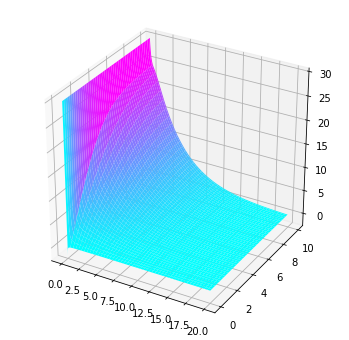

In [48]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T,Z, Rd,cmap='cool')

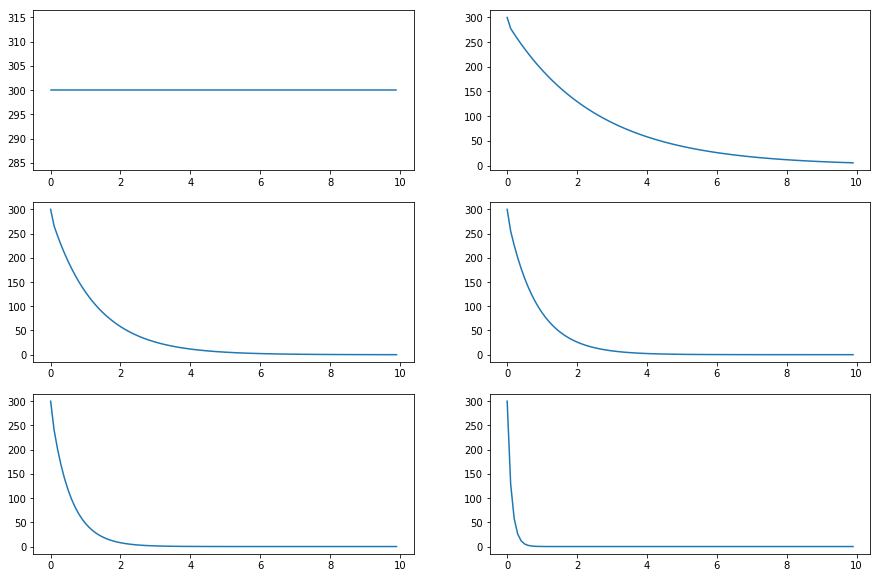

In [13]:
fig, axs = plt.subplots(3,2, figsize=(15,10))

axs[0,0].plot(z_grid,I[:,0])
axs[0,1].plot(z_grid,I[:,4000])
axs[1,0].plot(z_grid,I[:,8000])
axs[1,1].plot(z_grid,I[:,12000])
axs[2,0].plot(z_grid,I[:,18000])
axs[2,1].plot(z_grid,I[:,-1])

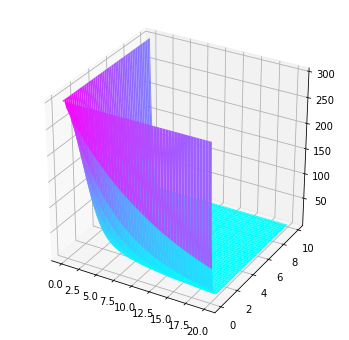

In [49]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T,Z, I,cmap='cool')